# Text Classification with Traditional Machine Learning Methods

#### 1 WordCloud
#### 2 Label Encoder / One Hot Encoder
#### 3 Count Vectorizer (bag of words)
#### 4 TF-IDF
#### 5 Tokenization / Stopwords / Lemmatization

In [1]:
%load_ext watermark
%watermark -v -p numpy,mlxtend,pandas,polars,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
mlxtend  : 0.23.1
pandas   : 2.2.1
polars   : 0.20.18
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

### WordCloud

- A wordcloud is a visual way to represent text data.
- The bigger a word is in the cloud, the more frequently it appears in the text and this helps you see what the main topics or themes are at a glance.

In [3]:
fp: str = "../../data/spam_data/spam.txt"

with open(fp, "r") as f:
    text: str = f.read()

text

'Dear MR tjones,\t\nYou have noticed lately that your laptop is running slow! This is because I gained access to your machine and I installed a harmful VIRUS!!!\nEven if you change your password my virus CANNOT BE intercepted!\nThe only SOLUTION is to follow my instructions here: http://goo.gl/ihsn9w\nYou have 48 hours before the virus is activated! ...OTHERWISE...GOOD LUCK!!!!\n'

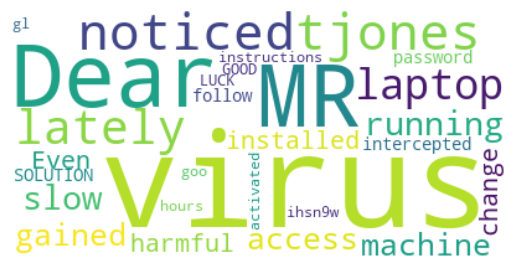

In [4]:
from wordcloud import WordCloud


wc = WordCloud(
    background_color="white", max_words=1000, contour_width=3, contour_color="steelblue"
)

# Generate a word cloud
word_cloud = wc.generate(text)

# Display the generated image:
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Label Encoder


In [5]:
import string


def tokenize(doc: str | list[str], drop_punct: bool = True) -> list[str]:
    """
    Tokenize the input document and optionally remove punctuation.

    Parameters
    ----------
    doc : str or list of str
        The input document as a string or list of strings.
    drop_punct : bool, optional
        Whether to remove punctuation (default is True).

    Returns
    -------
    list of str
        The tokenized document as a list of strings.
    """
    # Pattern for separating tokens
    pattern: str = r'([,.?_!"()\':]|\s)'

    if isinstance(doc, str):
        tok_doc: list[str] = re.split(pattern=pattern, string=doc.lower())

    if isinstance(doc, list):
        doc = [word.lower() for word in doc]
        tok_doc = re.split(pattern=pattern, string=" ".join(doc))

    # Remove whitespaces and empty strings
    tok_doc = [word for word in tok_doc if word.strip()]

    if drop_punct:
        tok_doc = [word for word in tok_doc if word not in string.punctuation]

    return tok_doc

In [6]:
from sklearn.preprocessing import LabelEncoder


text: str = "It is good to be a good person. I like good and honest people."
tok_text: list[str] = tokenize(doc=text)
print(f"{tok_text = }")

le: LabelEncoder = LabelEncoder()
txt_2_idx: np.ndarray = le.fit_transform(list(set(tok_text)))
print(f"{txt_2_idx = }")
idx_2_txt: np.ndarray = le.inverse_transform(txt_2_idx)
print(f"{idx_2_txt = }")
vocab: dict[str, Any] = {key: val for key, val in zip(idx_2_txt, txt_2_idx)}
console.print(f"{vocab = }")

tok_text = ['it', 'is', 'good', 'to', 'be', 'a', 'good', 'person', 'i', 'like', 'good', 'and', 'honest', 'people']
txt_2_idx = array([ 4,  3,  7,  0, 11, 10,  8,  9,  2,  5,  6,  1])
idx_2_txt = array(['honest', 'good', 'it', 'a', 'to', 'person', 'like', 'people',
       'be', 'i', 'is', 'and'], dtype='<U6')


vocab = {'honest': 4, 'good': 3, 'it': 7, 'a': 0, 'to': 11, 'person': 10, 'like': 8, 'people': 9, 'be': 2, 'i': 5, 
'is': 6, 'and': 1}

### One Hot Encoding

- Another well-known word representation technique is one-hot encoding, which codifies every word
as a vector with zeros and a single one.

In [7]:
from sklearn.preprocessing import OneHotEncoder


ohe: OneHotEncoder = OneHotEncoder(handle_unknown="ignore")
tok_text_arr: np.ndarray = np.array(tok_text).reshape(-1, 1)
ohe_arr: np.ndarray = ohe.fit_transform(tok_text_arr).toarray()

schema: dict[str, Any] = {col: pl.UInt8 for col in tok_text}
df: pl.DataFrame = pl.DataFrame(ohe_arr)
df.columns = sorted(set(tok_text))
df.to_pandas()

,a,and,be,good,honest,i,is,it,like,people,person,to
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Count Vectorizer (Term Frequency / Bag of Words)

- Token count encoding, also known as the Bag-of-Words (BoW) representation, counts the absolute
frequency of each word within a sentence or a document.
The input is represented as a bag of words without taking into account grammar or word order. 

In [8]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer: CountVectorizer = CountVectorizer()
count_vectors: np.ndarray = vectorizer.fit_transform([text]).toarray()
vocab: np.ndarray = vectorizer.vocabulary_
console.print(f"{text = }")
console.print(f"{vocab = }")
console.print(f"{count_vectors = }")

text = 'It is good to be a good person. I like good and honest people.'

vocab = {'it': 5, 'is': 4, 'good': 2, 'to': 9, 'be': 1, 'person': 8, 'like': 6, 'and': 0, 'honest': 3, 'people': 7}

count_vectors = array([[1, 1, 3, 1, 1, 1, 1, 1, 1, 1]])

#### Add n-grams

In [9]:
vectorizer: CountVectorizer = CountVectorizer(ngram_range=(2, 2))
count_vectors: np.ndarray = vectorizer.fit_transform([text]).toarray()
console.print(f"{text = }")
vocab: np.ndarray = vectorizer.vocabulary_
console.print(f"{vocab = }")
console.print(f"{count_vectors = }")

text = 'It is good to be a good person. I like good and honest people.'

vocab = {'it is': 7, 'is good': 6, 'good to': 4, 'to be': 10, 'be good': 1, 'good person': 3, 'person like': 9, 
'like good': 8, 'good and': 2, 'and honest': 0, 'honest people': 5}

count_vectors = array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

<br>

### [Term Frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

- Term frequency, tf(t,d), is the relative frequency of term t within document d.
- where $f_{t,d}$ is the number of times term t appears in document d and $\sum_{t' \in d} f_{t',d}$ is the total number of terms in document d.

$$tf(t,d) = \frac{f_{t,d}}{\sum_{t' \in d} f_{t',d}}$$

#### Dampen the Term Frequency

- Reduce weight of common words within documents.
- i.e. Lower importance of frequent terms per document.

$$log_{tf} = 1 + log(freq_{count} + 1)$$

- Here, 1 is added to both the logarithm and the frequency count to avoid taking the log of zero and to dampen the effect of term frequency.

#### Inverse Document Frequency

- The inverse document frequency is a `measure of how much information the word provides`, i.e., how common or rare it is across all documents.
- It is the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient)

$$ n_{t} = |d \in D: t \in d| $$
$$ idf_{(t,D)} = log (\frac{N}{n_{t} + 1}) + 1 $$

- where $N$ is the total number of documents in the corpus, $t \in d$ is the number of terms in a document, $d \in D$ is a document in the corpus $D$ and 1 is added to the denominator to avoid division-by-zero errors.
- $n_{t}$ is the number of documents that contain the term $t$.

- If the term is not in the corpus, this will lead to a division-by-zero.
  - It is therefore common to adjust the numerator and denominator by adding a smoothing term to avoid this.

## TF-IDF

- `BoW` treats all words equally, making common words like "the" important even though they carry little meaning.
- `tf-idf` addresses this by giving more weight to words that are uncommon in the document collection (corpus) but frequent within a specific document.

$$ tfidf = tf * idf $$
<hr>

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer


corpus: list[str] = [
    "We need to meet tomorrow at the cafeteria.",
    "Meet me tomorrow at the cafeteria.",
    "You have inherited millions of dollars.",
    "Millions of dollars just for you.",
]

vectorizer: TfidfVectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)
tfidf.toarray()

array([[0.31901032, 0.31901032, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.31901032, 0.        ,
        0.40462414, 0.        , 0.31901032, 0.40462414, 0.31901032,
        0.40462414, 0.        ],
       [0.3889911 , 0.3889911 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.49338588, 0.3889911 , 0.        ,
        0.        , 0.        , 0.3889911 , 0.        , 0.3889911 ,
        0.        , 0.        ],
       [0.        , 0.        , 0.37222485, 0.        , 0.47212003,
        0.47212003, 0.        , 0.        , 0.        , 0.37222485,
        0.        , 0.37222485, 0.        , 0.        , 0.        ,
        0.        , 0.37222485],
       [0.        , 0.        , 0.37222485, 0.47212003, 0.        ,
        0.        , 0.47212003, 0.        , 0.        , 0.37222485,
        0.        , 0.37222485, 0.        , 0.        , 0.        ,
        0.        , 0.37222485]])

### Cosine Similarity

In [11]:
console.print(corpus)

[
    'We need to meet tomorrow at the cafeteria.',
    'Meet me tomorrow at the cafeteria.',
    'You have inherited millions of dollars.',
    'Millions of dollars just for you.'
]

In [12]:
from sklearn.metrics.pairwise import cosine_similarity


tfidf_arr: np.ndarray = tfidf.toarray()

# Calculate the similarity between the 1st two sentences
# cosine_similarity(tfidf_arr[0].reshape(1, -1), tfidf_arr[1].reshape(1, -1))
cosine_similarity([tfidf_arr[0]], [tfidf_arr[1]])

array([[0.62046087]])

In [13]:
# Cosine similarity of the entire array
cosine_similarity(tfidf_arr)

array([[1.        , 0.62046087, 0.        , 0.        ],
       [0.62046087, 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.55420536],
       [0.        , 0.        , 0.55420536, 1.        ]])

## Data Preprocessing

### Tokenization

- `Tokenization` is the process of breaking down text into smaller pieces called tokens.
- These tokens can be individual characters, words, sentences, or even paragraphs, depending on the specific task.

In [14]:
import spacy
from spacy.tokens.doc import Doc

# Load the small English Model
nlp = spacy.load("en_core_web_sm")
text: str = "We need to meet tomorrow at the cafeteria."
print(f"{text = }")
doc: Doc = nlp(text)

text = 'We need to meet tomorrow at the cafeteria.'


In [15]:
for token in doc:
    print(token.text, token.pos_, token.dep_)

We PRON nsubj
need VERB ROOT
to PART aux
meet VERB xcomp
tomorrow NOUN npadvmod
at ADP prep
the DET det
cafeteria NOUN pobj
. PUNCT punct


In [16]:
# Tokenize the text
[tok.text for tok in doc]

['We', 'need', 'to', 'meet', 'tomorrow', 'at', 'the', 'cafeteria', '.']

In [17]:
# Sentence Tokenizer
corpus: list[str] = [
    "Hey!",
    "We need to meet tomorrow at the cafeteria.",
    "Meet me tomorrow at the cafeteria.",
    "You have inherited millions of dollars.",
    "Millions of dollars just for you.",
]

corpos_str: str = " ".join(corpus)
doc: Doc = nlp(corpos_str)

for sent in doc.sents:
    print(sent)

Hey!
We need to meet tomorrow at the cafeteria.
Meet me tomorrow at the cafeteria.
You have inherited millions of dollars.
Millions of dollars just for you.


#### Stopwords

- `Stopwords` are common words that are generally considered to carry little meaning on their own.
- They are frequently filtered out before further analysis because they tend to clutter the data and can even mislead algorithms.
- Different libraries use different lists of stopwords.

In [18]:
from wordcloud import STOPWORDS

# OR
# from spacy.lang.en.stop_words import STOP_WORDS


spacy_stopwords: set[str] = nlp.Defaults.stop_words
wc_stopwords = STOPWORDS

print(f"spacy stopwords: {len(spacy_stopwords)}")
print(f"wc stopwords: {len(wc_stopwords)}")

spacy stopwords: 326
wc stopwords: 192


### Lemmatization

- `Lemmatization` in NLP is the process of reducing words to their `base` or dictionary form, also known as their `lemma`.
- i.e. converting words with different inflections (like tense or plurality) to a single canonical form.
- Example: Let's consider the word `"running."` Lemmatization would convert it to its base form, `"run."` 
- Lemmatization applies to verbs, nouns, adjectives, and adverbs.

In [19]:
text: str = (
    "He asked him 'why do you want to become great?' "
    "I am the best version of myself."
)

# Lemmatize
doc: Doc = nlp(text)
for token in doc:
    print(f"text: {token.text}, lemma: {token.lemma_}")

text: He, lemma: he
text: asked, lemma: ask
text: him, lemma: he
text: ', lemma: '
text: why, lemma: why
text: do, lemma: do
text: you, lemma: you
text: want, lemma: want
text: to, lemma: to
text: become, lemma: become
text: great, lemma: great
text: ?, lemma: ?
text: ', lemma: '
text: I, lemma: I
text: am, lemma: be
text: the, lemma: the
text: best, lemma: good
text: version, lemma: version
text: of, lemma: of
text: myself, lemma: myself
text: ., lemma: .


### Create Training Data

- Copied from [here](https://github.com/PacktPublishing/Machine-Learning-Techniques-for-Text/blob/main/chapter-02/spam-detection.ipynb).

In [20]:
import email
import glob
from sklearn.model_selection import train_test_split


SEED: int = 123

# Load the path for each email file for both categories.
ham_files = train_test_split(
    glob.glob("../../data/spam_data/20030228_hard_ham/hard_ham/*"), random_state=SEED
)
spam_files = train_test_split(
    glob.glob("../../data/spam_data/20050311_spam_2/spam_2/*"), random_state=SEED
)


def get_content(filepath: str) -> str:
    """
    Get the content of an email.

    Parameters
    ----------
    filepath : str
        The path to the email file.

    Returns
    -------
    str
        The content of the email if it's of type 'text/plain', otherwise None.
    """
    file = open(filepath, encoding="latin1")
    message = email.message_from_file(file)

    for msg_part in message.walk():
        # Keep only messages with text/plain content.
        if msg_part.get_content_type() == "text/plain":
            return msg_part.get_payload()


# Get the training and testing data.
ham_train_data: list[str] = [get_content(i) for i in ham_files[0]]
ham_test_data: list[str] = [get_content(i) for i in ham_files[1]]
spam_train_data: list[str] = [get_content(i) for i in spam_files[0]]
spam_test_data: list[str] = [get_content(i) for i in spam_files[1]]

# Keep emails with non-empty content.
ham_train_data: list[str] = list(filter(None, ham_train_data))
ham_test_data: list[str] = list(filter(None, ham_test_data))
spam_train_data: list[str] = list(filter(None, spam_train_data))
spam_test_data: list[str] = list(filter(None, spam_test_data))

# Merge the train/test files for both categories.
train_data = np.concatenate((ham_train_data, spam_train_data))
test_data = np.concatenate((ham_test_data, spam_test_data))

# Assign a class for each email (ham = 0, spam = 1).
ham_train_class: list[int] = [0] * len(ham_train_data)
ham_test_class: list[int] = [0] * len(ham_test_data)
spam_train_class: list[int] = [1] * len(spam_train_data)
spam_test_class: list[int] = [1] * len(spam_test_data)

# Merge the train/test classes for both categories.
train_class: np.ndarray = np.concatenate((ham_train_class, spam_train_class))
test_class: np.ndarray = np.concatenate((ham_test_class, spam_test_class))

In [21]:
train_df: pl.DataFrame = pl.DataFrame(data={"text": train_data, "label": train_class})
test_df: pl.DataFrame = pl.DataFrame(data={"text": test_data, "label": test_class})

train_df.head(3)

text,label
str,i64
"""Today's Headlines from The Register ----------------------------------- To unsubscribe from this daily news update, see the instructions at the end of this message. --------ADVERTISEMENT------------------------------------------------ WIN tickets to a FORMULA ONE EUROPEAN GRAND PRIX! Neverfail Group plc, business continuity software expert, sponsors Rubens Barrichello driver of the Ferrari F1 team. Click here to find out more and win tickets: www.neverfailgroup.com/f1theregister.html. For every new customer that buys Neverfail(tm) products between the July-September 2002 Grand Prix season, Neverfail Group plc will grant 2 tickets to a Grand Prix hospitality event with us next 2003 season. --------------------------------------------------------------------- Software Preinstalled Mandrake Linux PCs go live at Walmart Will the public love them? http://www.theregister.co.uk/content/4/26192.html Confirmed: MS to ship beefed up 802.11 …",0
""" ***WROX PRESS DEVELOPER'S JOURNAL*** Programmer to Programmer(TM) http://www.wrox.com/?tid026 7/26/02 ========== IN THIS ISSUE ========== TITLE OF THE MONTH GEMS FROM THE CATALOGUE RECENTLY RELEASED FUTURE TITLES NEWS & FEATURES WROX ANNOUNCEMENTS OTHER ANNOUNCEMENTS INFORMATION FOR SUBSCRIBERS ========== TITLE OF THE MONTH ========== ASP.NET Namespace Reference with C# http://www.wrox.com/ACON11.asp?ISBN=1861007442&tid026 Introduction System.Web System.Web.UI System.Web.UI.HtmlControls System.Web.UI.WebControls System.Web.UI.MobileControls System.Web.Caching System.Web.Configuration System.Web.Security System.Web.Services System.Web.Services.Description System.Web.Services.Protocols Data in ASP.NET XML in ASP.NET Also available: ASP.NET 1.0 Namespace Reference with VB.NET http://www.wrox.com/ACON11.asp?ISBN=1861007450&tid026 ========== GEMS FROM THE CATALOGUE ========== Professional Linux Programming http://www.wrox.com/ACON11.asp?ISBN=1861003013&tid026 Introduction Chapte…",0
"""I did more testing with your patch on top of today's CVS, but the patch didn't help at all. The following is the results of the tests: Testing setup: 1. created a ""/dev/md0"" with 4 scsi disks 2. created a LVM Volume group ""vg"" with the ""/dev/md0"" 3. created a LVM logical volume ""vol1"" with ""vg"" 4. created a XFS fs with a command: mkfs.xfs -f -d sunit=8,swidth=8 /dev/vg/vol1 -----------meta-data=/dev/vg/vol1 isize=256 agcount=8, agsize=32767 blks -----------data = bsize=4096 blocks=262136, imaxpct=25 ----------- = sunit=1 swidth=1 blks, unwritten=0 -----------naming =version 2 bsize=4096 -----------log =internal log bsize=4096 blocks=1200, version=1 ----------- = sunit=1 blks -----------realtime =none extsz=65536 blocks=0, rtextents=0 Test results: 1. mount with quota enabled => occasional kernel o…",0


In [22]:
from utils import DataCleaner


df: pl.DataFrame = pl.DataFrame(
    {
        "text": [
            "@mike25: You gotta stop chasing the trends and be real #realMotivation.",
            (
                "Stay in the middle of truth and you will be successful. "
                "But stay in the middle of lies and you will fall victim to them."
            ),
            "#raiseSomeoneUp today__. #motivation #success #inspiration",
        ]
    }
)
df.head()

text
str
"""@mike25: You gotta stop chasing the trends and be real #realMotivation."""
"""Stay in the middle of truth and you will be successful. But stay in the middle of lies and you will fall victim to them."""
"""#raiseSomeoneUp today__. #motivation #success #inspiration"""


In [23]:
datacleaner: DataCleaner = DataCleaner(data=df, text_column="text")
print("\nremove_punctuation")
print(datacleaner.remove_punctuation(data=df))
print("\nlowercase_and_filter_stopwords")
print(datacleaner.lowercase_and_filter_stopwords(data=df))

print("\nprepare_data")
print(datacleaner.prepare_data())


remove_punctuation
shape: (3, 2)
┌─────────────────────────────────────────────────┬────────────────────────────────────────────────┐
│ text                                            ┆ cleaned_text                                   │
│ ---                                             ┆ ---                                            │
│ str                                             ┆ str                                            │
╞═════════════════════════════════════════════════╪════════════════════════════════════════════════╡
│ @mike25: You gotta stop chasing the trends and  ┆ mike25  You gotta stop chasing the trends and  │
│ be real #realMotivation.                        ┆ be real  realMotivation                        │
│ Stay in the middle of truth and you will be     ┆ Stay in the middle of truth and you will be    │
│ successful. But stay in the middle of lies and  ┆ successful  But stay in the middle of lies and │
│ you will fall victim to them.                   ┆ you w

In [24]:
datacleaner: DataCleaner = DataCleaner(data=train_df, text_column="text")
# train_df = datacleaner.lowercase_and_filter_stopwords(data=train_df)
train_df = datacleaner.prepare_data()

# === test data ===
datacleaner: DataCleaner = DataCleaner(data=test_df, text_column="text")
# test_df = datacleaner.lowercase_and_filter_stopwords(data=test_df)
test_df = datacleaner.prepare_data()

train_df.head(2)

text,label,cleaned_text
str,i64,str
"""Today's Headlines from The Register ----------------------------------- To unsubscribe from this daily news update, see the instructions at the end of this message. --------ADVERTISEMENT------------------------------------------------ WIN tickets to a FORMULA ONE EUROPEAN GRAND PRIX! Neverfail Group plc, business continuity software expert, sponsors Rubens Barrichello driver of the Ferrari F1 team. Click here to find out more and win tickets: www.neverfailgroup.com/f1theregister.html. For every new customer that buys Neverfail(tm) products between the July-September 2002 Grand Prix season, Neverfail Group plc will grant 2 tickets to a Grand Prix hospitality event with us next 2003 season. --------------------------------------------------------------------- Software Preinstalled Mandrake Linux PCs go live at Walmart Will the public love them? http://www.theregister.co.uk/content/4/26192.html Confirmed: MS to ship beefed up 802.11 …",0,"""today s headlines register unsubscribe daily news update instructions end message advertisement win tickets formula european grand prix neverfail group plc business continuity software expert sponsors rubens barrichello driver ferrari f team click find win tickets www neverfailgroup com ftheregister html new customer buys neverfail tm products july september grand prix season neverfail group plc grant tickets grand prix hospitality event season software preinstalled mandrake linux pcs live walmart public love confirmed ms ship beefed security xp sp surely reason upgrade wink amaze enterprise systems citrix pink slip cent decimation st century style personal hardware pc prices plummet europe mercy semiconductors mobile athlon amd fanboy spat intel price cuts hwroundupfunny underdog internet webmaster conference held london pub ll drink net security security industry s hacker pipming slammed somebody pgp vuln exposed outlook plug pretty poor privacy business interoute buys ebone e…"
""" ***WROX PRESS DEVELOPER'S JOURNAL*** Programmer to Programmer(TM) http://www.wrox.com/?tid026 7/26/02 ========== IN THIS ISSUE ========== TITLE OF THE MONTH GEMS FROM THE CATALOGUE RECENTLY RELEASED FUTURE TITLES NEWS & FEATURES WROX ANNOUNCEMENTS OTHER ANNOUNCEMENTS INFORMATION FOR SUBSCRIBERS ========== TITLE OF THE MONTH ========== ASP.NET Namespace Reference with C# http://www.wrox.com/ACON11.asp?ISBN=1861007442&tid026 Introduction System.Web System.Web.UI System.Web.UI.HtmlControls System.Web.UI.WebControls System.Web.UI.MobileControls System.Web.Caching System.Web.Configuration System.Web.Security System.Web.Services System.Web.Services.Description System.Web.Services.Protocols Data in ASP.NET XML in ASP.NET Also available: ASP.NET 1.0 Namespace Reference with VB.NET http://www.wrox.com/ACON11.asp?ISBN=1861007450&tid026 ========== GEMS FROM THE CATALOGUE ========== Professional Linux Programming http://www.wrox.com/ACON11.asp?ISBN=1861003013&tid026 Introduction Chapte…",0,"""wrox press developer s journal programmer programmer tm issue title month gems catalogue recently released future titles news features wrox announcements announcements information subscribers title month asp net namespace reference c introduction system web system web ui system web ui htmlcontrols system web ui webcontrols system web ui mobilecontrols system web caching system web configuration system web security system web services system web services description system web services protocols data asp net xml asp net available asp net namespace reference vb net gems catalogue professional linux programming introduction chapter application design chapter concurrent versions system cvs chapter databases chapter postgresql interfacing chapter mysql chapter tackling bugs chapter ldap directory services chapter gui programming gnome gtk chapter gui building glade gtk gnome chapter flex bison chapter testing tools chapter secure programming chapter gui programming kde qt…"


In [25]:
train_df = train_df.with_columns(text_length=pl.col("cleaned_text").str.len_chars())
train_df.describe()

statistic,text,label,cleaned_text,text_length
str,str,f64,str,f64
"""count""","""661""",661.0,"""661""",661.0
"""null_count""","""0""",0.0,"""0""",0.0
"""mean""",null,0.856278,null,2120.83056
"""std""",null,0.351073,null,4718.200888
"""min""",""" """,0.0,"""""",0.0
"""25%""",null,1.0,null,403.0
"""50%""",null,1.0,null,761.0
"""75%""",null,1.0,null,1753.0
"""max""","""¸å¼þ£ºÒ°ÂùÅ®ÓÑVS¡¶Ä§¹íÓ¢Óï¡· ¡±101½ÌÓýÍø¡°ÍÆ¼ö¡¶Ä§¹íÓ¢Óï¡· ¡±ÖÐ¹ú½ÌÓýÍø¡°ÍÆ¼ö¡¶Ä§¹íÓ¢Óï¡· ¸å¼þ£ºÈçºÎÉÁ(FLASH)µÄ¸ü¿áÒ»µã ¸å¼þ£ºÒ°ÂùÅ®ÓÑÏ²»¶ÖÐ¹ú¿á¸ç ¸å¼þ£ºÒ°ÂùÅ®ÓÑÏ²»¶ÂéÀ±¿á¸ç ¸å¼þ£ºeÊ±´ú£¬ÉÁ¿Í²»µÐ¿á¿Í ¸å¼þ£º¡¶Flash¿á×Ö¼¯¡·&¡¶Ä§¹íÓ¢Óï¡· ¡¶Flash¿á×Ö¼¯¡·""Ê·ÉÏ×îÇ¿Ö®Êý×Ö»¯ÖÐÎÄÒýÇæ"" ¡¶Ä§¹íÓ¢Óï¡·""²»ÓÃÑ§Óï·¨ ²»ÓÃ±³µ¥´Ê""³õÖÐÉúÒ²ÄÜ¿´Ó¢ÓïÔ­°æ¡°´óÆ¬¡±£¡ ¿´¡¶ÐÇÇò´óÕ½¡·£¬Ñ§¡¶Ä§¹íÓ¢Óï¡·£¡ ===================================== ¡¶Flash¿á×Ö¼¯¡·""Ê·ÉÏ×îÇ¿Ö®Êý×Ö»¯ÖÐÎÄÒýÇæ"" ¡¡¡¡¡¶Flash¿á×Ö¼¯¡· ÓÖÃû¡¶ÖÐ»ª´ó×Ö¿â¡·Flash°æ£¬ÊÇ¡¶ÖÐ»ª´ó×Ö¿â¡·µÄ×îÐÂ°æ±¾£¬ÏµÓÉÖÐ¹ú·¢Ã÷Ð­»á»áÔ±ºÎº£ÈºÏÈÉúÀúÊ±Ê®Äê£¬ºÄ×Ê¾Þ´óÍê³ÉµÄÒ»Ì×³¬´óÐÍÖÐÎÄ¸öÐÔ»¯ÊýÂë×Ö¿â£¬±»ÓþÎª¡°Ê·ÉÏ×îÇ¿Ö®Êý×Ö»¯ÖÐÎÄÒýÇæ¡±¡£ ¡¡¡¡×îÐÂÍÆ³öµÄ¡¶Flash¿á×Ö¼¯¡·¹²ÊÕÂ¼ÁË1000Ç§¶àÌ×TRUETYPEÖÐÎÄ×ÖÐÍ£¬ÊÇÄ¿Ç°È«ÇòÊ×Ì×Í»ÆÆ¡°Ç§Ì×¡±×ÖÐÍ´ó¹ØµÄÊý×Ö»¯ÖÐÎÄµçÄÔ×Ö¿â£¬Ò²ÊÇÎ¨Ò»ÄÜ¹»Ìá¹©Ç§Ì×¼¶½â¾ö·½°¸µÄÖÐÎÄ¸öÐÔ»¯ÏµÍ³Æ½Ì¨£¬ÊÇ¡°eÊ±´ú¡±ÍØÕ¹µç×ÓÉÌÎñÊ×Ñ¡µÄÖÐÎÄÆ½Ì¨¡£ ¡¡¡¡ÔÚ³¤´ïÊ®ÄêµÄÑÐ·¢¹ý³Ìµ±ÖÐ£¬ÓÐ¹Ø¼¼ÊõÈËÔ±¿Ë·þÖÖÖÖÀ§ÄÑ£¬´´½¨ÁËÒ»ÕûÌ×ÏµÍ³»¯¡¢¿ÆÑ§»¯µÄÖÐÎÄºº×ÖÐÎÌ¬ÑÐ¾¿ÀíÂÛ¡¢ÊýÑ§Ä£ÐÍ¼°ÊµÓÃ…",1.0,"""ù iáâáâ z úá w h ó idol j h u o z é jªº º e g noprovisions bonbox cz p á ë g life time upgrades free guaranteessnk spend upwards dvd burner alternative exact thing fraction cost copy dvd s best price net click click remove""",49327.0


In [26]:
# Filter out short texts
train_df = train_df.filter(pl.col("text_length").ge(30))
train_df.describe()

statistic,text,label,cleaned_text,text_length
str,str,f64,str,f64
"""count""","""657""",657.0,"""657""",657.0
"""null_count""","""0""",0.0,"""0""",0.0
"""mean""",null,0.855403,null,2133.724505
"""std""",null,0.351962,null,4729.655854
"""min""",""" Aren't Asian Pacfic Americans (APAs) accorded equal opportunity already? Unfortunately, no. APAs are not accorded equal opportunity in workplaces presently. Equal opportunity means: ""For every man, woman and child to go as far and rise as high as their ambition and ability will take them."" Statistics, mostly gathered by government studies, show that AAs have only 1/3 the opportunity of all other Americans to rise to the top in the academic world, corporate world, the federal government. There seems to exist an invisible resistance to AAs' developing to the maximal of their potentials -- A Glass Ceiling. Let's look at a concrete case. A lot of our best people are employed in universities. Their average performance has been outstanding. What's their chance of rising to the top? University administrators are recruited almost exclusively from the ranks of faculty and professionals already employed in universities. Hence the ratio of [administrators / (fa…",0.0,""" s school buynow don t feel lots special offers great competition cheer win online gift voucher buynow august th th find apples buynow partner sites enter draw everytime find apple click enter login email address password enter times want apples find chances eason school books academic titles ect ionid d spend free delivery multimedia desk d level d type d ideal study home office handheld voice email unit d record message store email music study tar d great savings dmgdirect s summer sale nike brazil backpack tor eid d level d type d sure seen bright bag spacey pen o d type d funny funky yrs old pack school shirts lev el d type d hassle order schoolwear arnotts ie tape dispenser o d type d add touch kitsch desk flowery dispenser lord rings dvd set dmgdirect discs set contains fellowship ring plus lots extra features rrp online price buynow members save s choice convenience control register today aib s internet phone banking se…",31.0
"""25%""",null,1.0,null,408.0
"""50%""",null,1.0,null,773.0
"""75%""",null,1.0,null,1762.0
"""max""","""¸å¼þ£ºÒ°ÂùÅ®ÓÑVS¡¶Ä§¹íÓ¢Óï¡· ¡±101½ÌÓýÍø¡°ÍÆ¼ö¡¶Ä§¹íÓ¢Óï¡· ¡±ÖÐ¹ú½ÌÓýÍø¡°ÍÆ¼ö¡¶Ä§¹íÓ¢Óï¡· ¸å¼þ£ºÈçºÎÉÁ(FLASH)µÄ¸ü¿áÒ»µã ¸å¼þ£ºÒ°ÂùÅ®ÓÑÏ²»¶ÖÐ¹ú¿á¸ç ¸å¼þ£ºÒ°ÂùÅ®ÓÑÏ²»¶ÂéÀ±¿á¸ç ¸å¼þ£ºeÊ±´ú£¬ÉÁ¿Í²»µÐ¿á¿Í ¸å¼þ£º¡¶Flash¿á×Ö¼¯¡·&¡¶Ä§¹íÓ¢Óï¡· ¡¶Flash¿á×Ö¼¯¡·""Ê·ÉÏ×îÇ¿Ö®Êý×Ö»¯ÖÐÎÄÒýÇæ"" ¡¶Ä§¹íÓ¢Óï¡·""²»ÓÃÑ§Óï·¨ ²»ÓÃ±³µ¥´Ê""³õÖÐÉúÒ²ÄÜ¿´Ó¢ÓïÔ­°æ¡°´óÆ¬¡±£¡ ¿´¡¶ÐÇÇò´óÕ½¡·£¬Ñ§¡¶Ä§¹íÓ¢Óï¡·£¡ ===================================== ¡¶Flash¿á×Ö¼¯¡·""Ê·ÉÏ×îÇ¿Ö®Êý×Ö»¯ÖÐÎÄÒýÇæ"" ¡¡¡¡¡¶Flash¿á×Ö¼¯¡· ÓÖÃû¡¶ÖÐ»ª´ó×Ö¿â¡·Flash°æ£¬ÊÇ¡¶ÖÐ»ª´ó×Ö¿â¡·µÄ×îÐÂ°æ±¾£¬ÏµÓÉÖÐ¹ú·¢Ã÷Ð­»á»áÔ±ºÎº£ÈºÏÈÉúÀúÊ±Ê®Äê£¬ºÄ×Ê¾Þ´óÍê³ÉµÄÒ»Ì×³¬´óÐÍÖÐÎÄ¸öÐÔ»¯ÊýÂë×Ö¿â£¬±»ÓþÎª¡°Ê·ÉÏ×îÇ¿Ö®Êý×Ö»¯ÖÐÎÄÒýÇæ¡±¡£ ¡¡¡¡×îÐÂÍÆ³öµÄ¡¶Flash¿á×Ö¼¯¡·¹²ÊÕÂ¼ÁË1000Ç§¶àÌ×TRUETYPEÖÐÎÄ×ÖÐÍ£¬ÊÇÄ¿Ç°È«ÇòÊ×Ì×Í»ÆÆ¡°Ç§Ì×¡±×ÖÐÍ´ó¹ØµÄÊý×Ö»¯ÖÐÎÄµçÄÔ×Ö¿â£¬Ò²ÊÇÎ¨Ò»ÄÜ¹»Ìá¹©Ç§Ì×¼¶½â¾ö·½°¸µÄÖÐÎÄ¸öÐÔ»¯ÏµÍ³Æ½Ì¨£¬ÊÇ¡°eÊ±´ú¡±ÍØÕ¹µç×ÓÉÌÎñÊ×Ñ¡µÄÖÐÎÄÆ½Ì¨¡£ ¡¡¡¡ÔÚ³¤´ïÊ®ÄêµÄÑÐ·¢¹ý³Ìµ±ÖÐ£¬ÓÐ¹Ø¼¼ÊõÈËÔ±¿Ë·þÖÖÖÖÀ§ÄÑ£¬´´½¨ÁËÒ»ÕûÌ×ÏµÍ³»¯¡¢¿ÆÑ§»¯µÄÖÐÎÄºº×ÖÐÎÌ¬ÑÐ¾¿ÀíÂÛ¡¢ÊýÑ§Ä£ÐÍ¼°ÊµÓÃ…",1.0,"""ù iáâáâ z úá w h ó idol j h u o z é jªº º e g noprovisions bonbox cz p á ë g life time upgrades free guaranteessnk spend upwards dvd burner alternative exact thing fraction cost copy dvd s best price net click click remove""",49327.0


In [27]:
# The data is imbalanced.
np.bincount(train_class)

array([ 95, 566])

#### Tokenize and Lemmatize

In [28]:
train_data: list[str] = train_df.select("cleaned_text").to_series().to_list()
test_data: list[str] = test_df.select("cleaned_text").to_series().to_list()
train_data[0][:20]

'today s headlines re'

In [29]:
sentences: list[str] = ["This is the 1st sentence.", "Talking 2nd sentence."]
doc: Doc = nlp(" ".join(sentences))

for sent in doc.sents:
    print("Sentence:", sent)
    print("Tokens:", [token.lemma_ for token in sent])
    print()

Sentence: This is the 1st sentence.
Tokens: ['this', 'be', 'the', '1st', 'sentence', '.']

Sentence: Talking 2nd sentence.
Tokens: ['talk', '2nd', 'sentence', '.']



In [30]:
# More efficient
# Remember to keep the `tagger` for lemmatization
doc = list(nlp.pipe(sentences, disable=["parser", "ner"]))

for sent in doc:
    print("Sentence:", sent)
    print("Tokens:", [token.lemma_ for token in sent])
    print()

Sentence: This is the 1st sentence.
Tokens: ['this', 'be', 'the', '1st', 'sentence', '.']

Sentence: Talking 2nd sentence.
Tokens: ['talk', '2nd', 'sentence', '.']



In [31]:
from spacy.tokens import Token
from spacy.tokens import Doc


# Register the 'lemma' extension
Token.set_extension("lemma", default=None, force=True)


def custom_lemmatizer(token: Token) -> str:
    """
    Custom lemmatizer function for removing the 'ing' suffix from
    gerunds/present participles.

    Parameters
    ----------
    token : Token
        A spaCy Token object.

    Returns
    -------
    str
        The lemmatized form of the token.
    """
    if token.tag_ == "VBG":  # Check if it's a gerund/present participle
        return token.lemma_.rstrip("ing")  # Remove 'ing' from the end of the lemma
    return token.lemma_  # Default to spaCy's lemmatizer for other cases


# Set the custom lemmatizer as a getter for the 'custom_lemma' extension
Token.set_extension("custom_lemma", getter=custom_lemmatizer, force=True)


def spacy_tokenize(text: str | list[str], lemmatize: bool = True) -> list[list[str]]:
    """
    Tokenize and optionally lemmatize text using spaCy.

    Parameters
    ----------
    text: str | list[str]
        Input text or list of texts to process.
    lemmatize : bool, optional
        Whether to lemmatize tokens, by default True.

    Returns
    -------
    list[list[str]]
        A list of lists, where each inner list contains tokens or lemmas for a sentence.

    Notes
    -----
    The shape of the output array is (n_sentences, n_tokens_per_sentence).
    """
    if isinstance(text, str):
        text = [text]
    my_doc: list[Doc] = list(nlp.pipe(text, disable=["parser", "ner"]))

    result: list[list[str]] = []
    for sent in my_doc:
        if lemmatize:  # use the custom lemmatizer
            result.append([token._.custom_lemma for token in sent])
        else:
            result.append([token.text for token in sent])

    return result

In [32]:
docs: list[str] = ["my name was Neidu", "I'm an NLP researcher. I am cooking"]

w_o_lemma: list[list[str]] = spacy_tokenize(text=docs, lemmatize=False)
with_lemma: list[list[str]] = spacy_tokenize(text=docs, lemmatize=True)
print(f"{w_o_lemma = }")
print(f"{with_lemma = }")

w_o_lemma = [['my', 'name', 'was', 'Neidu'], ['I', "'m", 'an', 'NLP', 'researcher', '.', 'I', 'am', 'cooking']]
with_lemma = [['my', 'name', 'be', 'neidu'], ['I', 'be', 'an', 'NLP', 'researcher', '.', 'I', 'be', 'cook']]


In [33]:
train_data_doc: list[list[str]] = spacy_tokenize(text=train_data, lemmatize=True)
test_data_doc: list[list[str]] = spacy_tokenize(text=test_data, lemmatize=True)

In [34]:
console.print(train_data_doc[0][:30])

[
    'today',
    's',
    'headline',
    'register',
    'unsubscribe',
    'daily',
    'news',
    'update',
    'instruction',
    'end',
    'message',
    'advertisement',
    'win',
    'ticket',
    'formula',
    'european',
    'grand',
    'prix',
    'neverfail',
    'group',
    'plc',
    'business',
    'continuity',
    'software',
    'expert',
    'sponsor',
    'ruben',
    'barrichello',
    'driver',
    'ferrari'
]

In [35]:
# Reconstruct the data. i.e list[list[str]] -> list[str]
train_data: list[str] = [" ".join(x) for x in train_data_doc]
test_data: list[str] = [" ".join(x) for x in test_data_doc]

train_class: np.ndarray = train_df.select("label").to_series().to_numpy()

train_data[0][:30]

'today s headline register unsu'

#### Extract The Features

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer: TfidfVectorizer = TfidfVectorizer(
    max_features=25_000,  # each record has max 25_000 features
    # ngram_range=(2, 2),
)

# Learn the params
tfidf_vectorizer.fit(train_data)

# Extract the features
train_data_features: np.ndarray = tfidf_vectorizer.transform(train_data)
test_data_features: np.ndarray = tfidf_vectorizer.transform(test_data)

print(f"Train data shape: {train_data_features.shape}")
print(f"Test data shape: {test_data_features.shape}")

Train data shape: (657, 19957)
Test data shape: (226, 19957)


In [37]:
train_data_features

<657x19957 sparse matrix of type '<class 'numpy.float64'>'
	with 88022 stored elements in Compressed Sparse Row format>

### Over-sample The Minority Class

In [38]:
from imblearn.combine import SMOTETomek


# Initialize SMOTETomek
smote_tomek = SMOTETomek(random_state=SEED)

# Apply SMOTETomek to the training data
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(
    train_data_features.toarray(), train_class
)

np.bincount(y_train_resampled)

array([562, 562])

<hr><br>

### Class Weight Calculation

- It's useful when the class distribution is highly skewed (imbalanced).
- A common method to compute class weights is to use:
$$ weight = \frac{N}{n_{samples} * n_{class}} $$

Where:

- $N$ is the `total number of samples`
- $n_{samples}$ is the `number of samples per class`
- and $n_{class}$ is the `number of classes`.

<br>

- E.g. If you have two class labels, label_A (20%) and label_B (80%), the class weight is:
  - label_A: (N / (20% * 2 * N)) = 1 / 0.4 = **2.5**
  - label_B: (N / (80% * 2 * N)) = 1 / 1.6 = **0.625**

In [39]:
def calculate_class_weights(
    n_samples: int, total_samples: int, n_classes: int
) -> float:
    return np.round(total_samples / (n_samples * n_classes), 4)


calculate_class_weights(n_samples=80, total_samples=100, n_classes=2)

0.625

In [40]:
# Calculate class weights
n_ham: int = len(y_train_resampled[y_train_resampled == 0])
n_spam: int = len(y_train_resampled[y_train_resampled == 1])
total_samples: int = len(y_train_resampled)
n_classes: int = np.unique(y_train_resampled).size

print(
    f"Number of ham: {n_ham}, Number of spam: {n_spam}, "
    f"Total samples: {total_samples}, Number of classes: {n_classes}"
)
class_weights = {
    0: calculate_class_weights(
        n_samples=n_ham, total_samples=total_samples, n_classes=n_classes
    ),
    1: calculate_class_weights(
        n_samples=n_spam, total_samples=total_samples, n_classes=n_classes
    ),
}
class_weights

Number of ham: 562, Number of spam: 562, Total samples: 1124, Number of classes: 2


{0: 1.0, 1: 1.0}

In [41]:
from sklearn.svm import SVC


# svm_clf: SVC = SVC(
#     kernel="rbf",
#     C=1.0,
#     gamma=1.0,
#     random_state=SEED,
#     class_weight=class_weights,
#     probability=True,
# )

# # Fit
# svm_clf.fit(X_train_resampled, y_train_resampled)

# # Classification score
# train_classif_score: float = svm_clf.score(X_train_resampled, y_train_resampled)
# print(f"Train classification score: {train_classif_score}")

# test_classif_score: float = svm_clf.score(test_data_features.toarray(), test_class)
# print(f"Test classification score: {test_classif_score}")

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


svm_pipe: Pipeline = Pipeline(
    steps=[
        # ("tfidf_vectorizer", TfidfVectorizer(max_features=25_000)),
        # ("to_dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
        (
            "clf",
            SVC(
                kernel="rbf",
                C=1.0,
                gamma=1.0,
                random_state=SEED,
                class_weight=class_weights,
                probability=True,
            ),
        ),
    ]
)
svm_pipe

Pipeline(steps=[('clf',
                 SVC(class_weight={0: 1.0, 1: 1.0}, gamma=1.0, probability=True,
                     random_state=123))])

In [43]:
import time
from sklearn.model_selection import StratifiedKFold


def train_model_with_cross_validation(
    X: np.ndarray,
    y: np.ndarray,
    estimator: Any,
    n_splits: int = 5,
) -> tuple[Any, list[float], float, float]:
    """
    Train a model using cross-validation and return performance metrics.

    Parameters
    ----------
    X : np.ndarray
        Input features array of shape (n_samples, n_features).
    y : np.ndarray
        Target labels array of shape (n_samples,).
    estimator : Any
        The machine learning model to be trained and evaluated.
    n_splits : int, optional
        Number of splits for cross-validation, by default 5.

    Returns
    -------
    tuple[Any, list[float], float, float]
        A tuple containing:
        - The trained estimator
        - List of accuracy scores for each fold
        - Mean accuracy across all folds
        - Standard deviation of accuracy across all folds
    """
    start_time: float = time.time()
    kfold: StratifiedKFold = StratifiedKFold(n_splits=n_splits).split(X, y)

    scores: list[float] = []

    for k, (train, test) in enumerate(kfold):
        estimator.fit(X[train], y[train])
        score: float = estimator.score(X[test], y[test])
        scores.append(score)
        print(
            f"Fold: {k+1:2d} | Class dist.: {np.bincount(y[train])} | Acc: {score:.3f}"
        )

    mean_accuracy: float = np.mean(scores)
    std_accuracy: float = np.std(scores)
    stop_time: float = time.time()
    print(f"\nCV accuracy: {mean_accuracy:.3f} +/- {std_accuracy:.3f}")
    print(f"\nTime taken: {stop_time - start_time:.3f} seconds")

    return estimator, scores, mean_accuracy, std_accuracy

In [44]:
svm_pipe, _, _, _ = train_model_with_cross_validation(
    X_train_resampled, y_train_resampled, estimator=svm_pipe, n_splits=5
)

Fold:  1 | Class dist.: [449 450] | Acc: 0.929
Fold:  2 | Class dist.: [449 450] | Acc: 1.000
Fold:  3 | Class dist.: [450 449] | Acc: 1.000
Fold:  4 | Class dist.: [450 449] | Acc: 1.000
Fold:  5 | Class dist.: [450 450] | Acc: 0.996

CV accuracy: 0.985 +/- 0.028

Time taken: 144.637 seconds


In [45]:
from sklearn import metrics


# === Recall ===
y_pred_train: np.ndarray = svm_pipe.predict(train_data_features.toarray())
y_pred_test: np.ndarray = svm_pipe.predict(test_data_features.toarray())

train_recall_score: float = metrics.recall_score(
    y_true=train_class, y_pred=y_pred_train
)
test_recall_score: float = metrics.recall_score(y_true=test_class, y_pred=y_pred_test)

print(
    f"Train Recall Score: {train_recall_score:.4f}\nTest Recall Score: {test_recall_score:.4f}"
)

Train Recall Score: 0.9964
Test Recall Score: 0.9737


In [46]:
# === Precision ===
train_precision_score: float = metrics.precision_score(
    y_true=train_class, y_pred=y_pred_train
)
test_precision_score: float = metrics.precision_score(
    y_true=test_class, y_pred=y_pred_test
)

print(
    f"Train Precision Score: {train_precision_score:.4f}\nTest Precision Score: {test_precision_score:.4f}"
)

Train Precision Score: 1.0000
Test Precision Score: 0.9113


In [47]:
# === ROC AUC ===
# Shape: (n_samples, n_classes)[:, 1] -> (n_samples, )
y_proba_train: np.ndarray = svm_pipe.predict_proba(train_data_features.toarray())[:, 1]
y_proba_test: np.ndarray = svm_pipe.predict_proba(test_data_features.toarray())[:, 1]


train_auc_score: float = metrics.roc_auc_score(
    y_true=train_class, y_score=y_proba_train
)
test_auc_score: float = metrics.roc_auc_score(y_true=test_class, y_score=y_proba_test)

print(f"Train AUC Score: {train_auc_score:.4f}\nTest AUC Score: {test_auc_score:.4f}")

Train AUC Score: 0.9976
Test AUC Score: 0.9744


In [48]:
# Shape: (n_samples, n_classes)[:, 1] -> (n_samples, )
y_proba_train.shape

(657,)

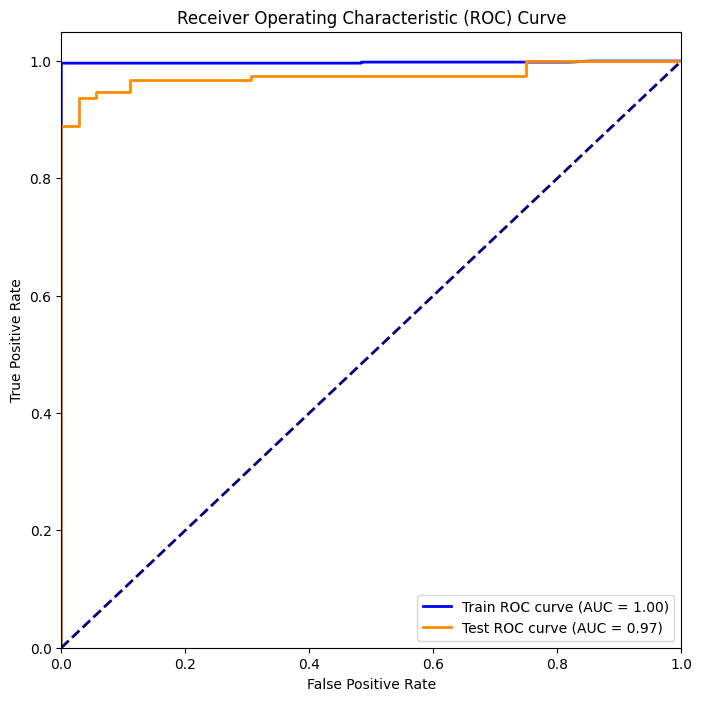

In [49]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for train set
fpr_train, tpr_train, _ = roc_curve(train_class, y_proba_train)
roc_auc_train: float = auc(fpr_train, tpr_train)

# Calculate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(test_class, y_proba_test)
roc_auc_test: float = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(
    fpr_train,
    tpr_train,
    color="blue",
    lw=2,
    label=f"Train ROC curve (AUC = {roc_auc_train:.2f})",
)
plt.plot(
    fpr_test,
    tpr_test,
    color="darkorange",
    lw=2,
    label=f"Test ROC curve (AUC = {roc_auc_test:.2f})",
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_comfusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, title: str) -> None:

    # Calculate confusion matrices
    cm_arr: np.ndarray = confusion_matrix(y_true, y_pred)

    # Plot confusion matrices
    plt.figure(figsize=(6, 6))

    sns.heatmap(cm_arr, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.tight_layout()
    plt.show()

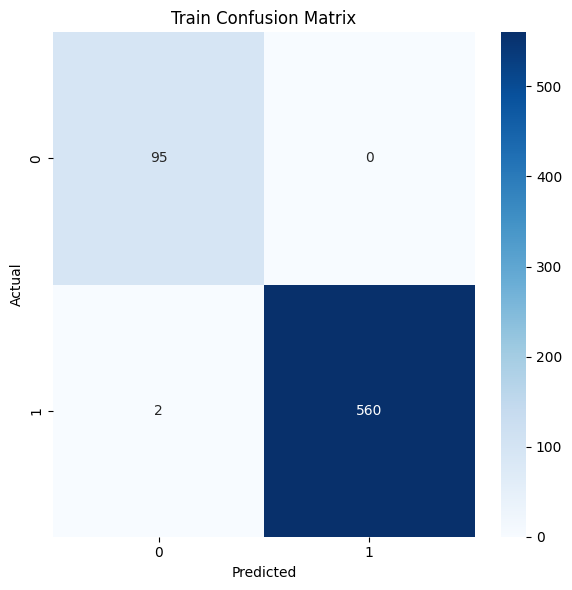

In [51]:
plot_comfusion_matrix(train_class, y_pred_train, title="Train Confusion Matrix")

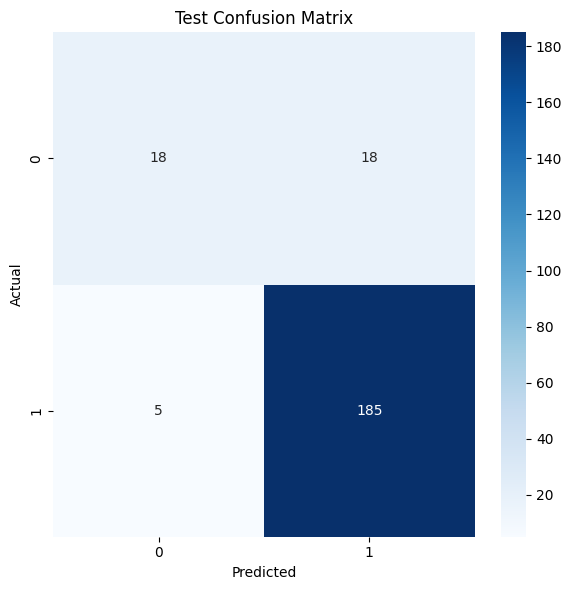

In [52]:
plot_comfusion_matrix(test_class, y_pred_test, title="Test Confusion Matrix")

### Precision Recall Curve

- Graphical tool showing the trade-off between precision and recall at various classification thresholds.

- Particularly useful for evaluating models on imbalanced datasets.

- High area under the curve indicates good model performance with both high precision and recall.

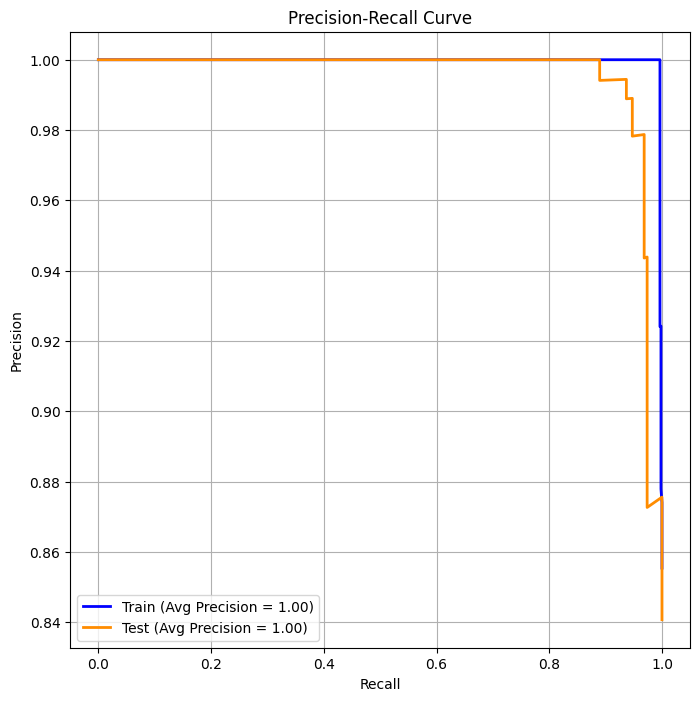

In [53]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall curves
precision_train, recall_train, _ = precision_recall_curve(train_class, y_proba_train)
precision_test, recall_test, _ = precision_recall_curve(test_class, y_proba_test)

# Calculate average precision scores
ap_train: float = average_precision_score(train_class, y_proba_train)
ap_test: float = average_precision_score(test_class, y_proba_test)

# Plot precision-recall curves
plt.figure(figsize=(8, 8))
plt.plot(
    recall_train,
    precision_train,
    color="blue",
    lw=2,
    label=f"Train (Avg Precision = {ap_train:.2f})",
)
plt.plot(
    recall_test,
    precision_test,
    color="darkorange",
    lw=2,
    label=f"Test (Avg Precision = {ap_test:.2f})",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

### Random Forests

In [54]:
from sklearn.ensemble import RandomForestClassifier


rf_pipe: Pipeline = Pipeline(
    steps=[
        # ("tfidf_vectorizer", TfidfVectorizer(max_features=25_000)),
        # ("to_dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
        ("clf", RandomForestClassifier(n_estimators=100, random_state=SEED)),
    ]
)
rf_pipe

Pipeline(steps=[('clf', RandomForestClassifier(random_state=123))])

In [55]:
rf_pipe, _, _, _ = train_model_with_cross_validation(
    X_train_resampled, y_train_resampled, estimator=rf_pipe, n_splits=5
)

Fold:  1 | Class dist.: [449 450] | Acc: 0.876
Fold:  2 | Class dist.: [449 450] | Acc: 1.000
Fold:  3 | Class dist.: [450 449] | Acc: 0.987
Fold:  4 | Class dist.: [450 449] | Acc: 0.973
Fold:  5 | Class dist.: [450 450] | Acc: 0.991

CV accuracy: 0.965 +/- 0.046

Time taken: 8.257 seconds


### Diagnosing Model Issues

[![image.png](https://i.postimg.cc/Pr9q5Ks6/image.png)](https://postimg.cc/svPznY2S)

- [image source](https://subscription.packtpub.com/book/data/9781801819312/6/ch06lvl1sec38/debugging-algorithms-with-learning-and-validation-curves)

In [56]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(
    estimator: object,
    X: np.ndarray,
    y: np.ndarray,
    train_sizes: np.ndarray = np.linspace(0.1, 1.0, 10),
    cv: int = 5,
) -> None:
    """
    Plot the learning curve for a given estimator.

    Parameters
    ----------
    estimator : object
        The machine learning model to evaluate.
    X : np.ndarray of shape (n_samples, n_features)
        The input samples.
    y : np.ndarray of shape (n_samples,)
        The target values.
    train_sizes : np.ndarray of shape (n_points,), default=np.linspace(0.1, 1.0, 10)
        The points of the learning curve to evaluate.
    cv : int, default=5
        The number of folds in cross-validation.

    Returns
    -------
    None
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        # n_jobs=1,
    )

    train_mean: np.ndarray = np.mean(train_scores, axis=1)
    train_std: np.ndarray = np.std(train_scores, axis=1)
    test_mean: np.ndarray = np.mean(test_scores, axis=1)
    test_std: np.ndarray = np.std(test_scores, axis=1)

    plt.plot(
        train_sizes,
        train_mean,
        color="blue",
        marker="o",
        markersize=5,
        label="Training accuracy",
    )

    plt.fill_between(
        train_sizes,
        train_mean + train_std,
        train_mean - train_std,
        alpha=0.15,
        color="blue",
    )

    plt.plot(
        train_sizes,
        test_mean,
        color="green",
        linestyle="--",
        marker="s",
        markersize=5,
        label="Validation accuracy",
    )

    plt.fill_between(
        train_sizes,
        test_mean + test_std,
        test_mean - test_std,
        alpha=0.15,
        color="green",
    )

    plt.grid()
    plt.xlabel("Number of training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.ylim([0.5, 1.03])
    plt.tight_layout()
    plt.show()

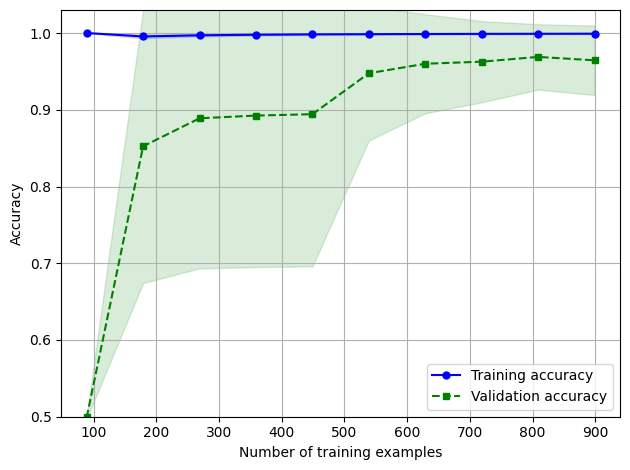

In [57]:
plot_learning_curve(rf_pipe, X_train_resampled, y_train_resampled)

In [58]:
# === Recall ===
y_pred_train: np.ndarray = rf_pipe.predict(train_data_features.toarray())
y_pred_test: np.ndarray = rf_pipe.predict(test_data_features.toarray())

train_recall_score: float = metrics.recall_score(
    y_true=train_class, y_pred=y_pred_train
)
test_recall_score: float = metrics.recall_score(y_true=test_class, y_pred=y_pred_test)

print(
    f"Train Recall Score: {train_recall_score:.4f}\nTest Recall Score: {test_recall_score:.4f}"
)

Train Recall Score: 0.9947
Test Recall Score: 0.9947


In [59]:
# === Precision ===
train_precision_score: float = metrics.precision_score(
    y_true=train_class, y_pred=y_pred_train
)
test_precision_score: float = metrics.precision_score(
    y_true=test_class, y_pred=y_pred_test
)

print(
    f"Train Precision Score: {train_precision_score:.4f}\nTest Precision Score: {test_precision_score:.4f}"
)

Train Precision Score: 1.0000
Test Precision Score: 0.9356


In [60]:
# === ROC AUC ===
# Shape: (n_samples, n_classes)[:, 1] -> (n_samples, )
y_proba_train: np.ndarray = rf_pipe.predict_proba(train_data_features.toarray())[:, 1]
y_proba_test: np.ndarray = rf_pipe.predict_proba(test_data_features.toarray())[:, 1]


train_auc_score: float = metrics.roc_auc_score(
    y_true=train_class, y_score=y_proba_train
)
test_auc_score: float = metrics.roc_auc_score(y_true=test_class, y_score=y_proba_test)

print(f"Train AUC Score: {train_auc_score:.4f}\nTest AUC Score: {test_auc_score:.4f}")

Train AUC Score: 0.9993
Test AUC Score: 0.9743


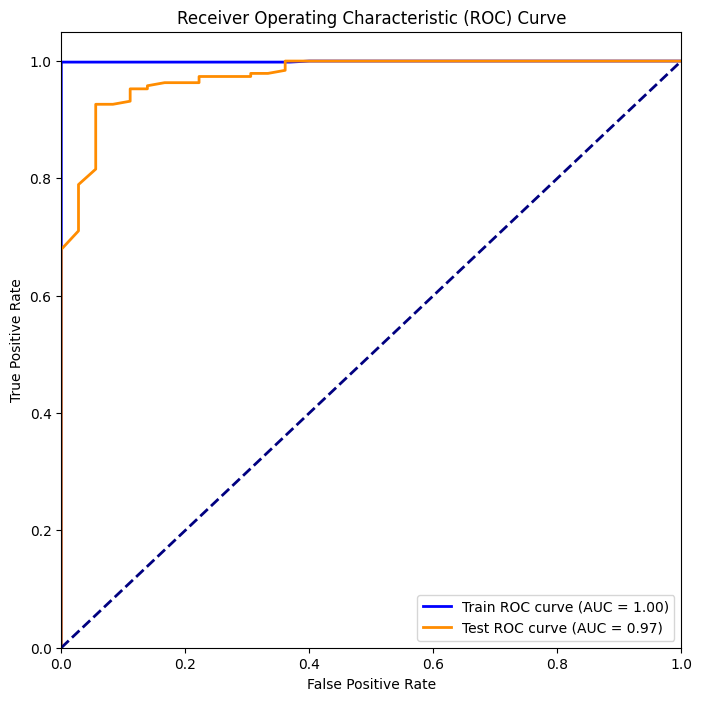

In [61]:
# Calculate ROC curve for train set
fpr_train, tpr_train, _ = roc_curve(train_class, y_proba_train)
roc_auc_train: float = auc(fpr_train, tpr_train)

# Calculate ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(test_class, y_proba_test)
roc_auc_test: float = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(
    fpr_train,
    tpr_train,
    color="blue",
    lw=2,
    label=f"Train ROC curve (AUC = {roc_auc_train:.2f})",
)
plt.plot(
    fpr_test,
    tpr_test,
    color="darkorange",
    lw=2,
    label=f"Test ROC curve (AUC = {roc_auc_test:.2f})",
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

### Voting Classifier

In [62]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score


voting_clf: VotingClassifier = VotingClassifier(
    estimators=[("svm", svm_pipe), ("rf", rf_pipe)],
    voting="soft",
    weights=[0.5, 0.5],
)
clf_labels: list[str] = ["Support Vector Clf", "Random Forest Clf", "Voting Clf"]
all_clf: list[Any] = [svm_pipe, rf_pipe, voting_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(
        estimator=clf, X=X_train_resampled, y=y_train_resampled, cv=5, scoring="roc_auc"
    )
    print(f"ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]")

ROC AUC: 1.00 (+/- 0.00) [Support Vector Clf]
ROC AUC: 0.99 (+/- 0.01) [Random Forest Clf]
ROC AUC: 1.00 (+/- 0.00) [Voting Clf]


In [63]:
voting_clf, _, _, _ = train_model_with_cross_validation(
    X_train_resampled, y_train_resampled, estimator=voting_clf, n_splits=5
)

Fold:  1 | Class dist.: [449 450] | Acc: 0.942
Fold:  2 | Class dist.: [449 450] | Acc: 1.000
Fold:  3 | Class dist.: [450 449] | Acc: 1.000
Fold:  4 | Class dist.: [450 449] | Acc: 1.000
Fold:  5 | Class dist.: [450 450] | Acc: 0.996

CV accuracy: 0.988 +/- 0.023

Time taken: 161.041 seconds


In [64]:
# === Recall ===
y_pred_train: np.ndarray = voting_clf.predict(train_data_features.toarray())
y_pred_test: np.ndarray = voting_clf.predict(test_data_features.toarray())

train_recall_score: float = metrics.recall_score(
    y_true=train_class, y_pred=y_pred_train
)
test_recall_score: float = metrics.recall_score(y_true=test_class, y_pred=y_pred_test)

print(
    f"Train Recall Score: {train_recall_score:.4f}\nTest Recall Score: {test_recall_score:.4f}"
)

Train Recall Score: 0.9964
Test Recall Score: 0.9737


### Observation

- Due to the limited number of `ham` emails, the model is not able to accurately classify `ham` emails.
- The model is biased towards classifying `ham` emails as `spam` emails.

In [65]:
text: str = (
    "Hello Fred! You just won $5,000. How exciting! Reply this email now to claim your prize!"
)
text_feat: np.ndarray = tfidf_vectorizer.transform([text])
voting_clf.predict(text_feat.toarray())

array([1])

In [66]:
text: str = "Good morning Amaka."
text_feat: np.ndarray = tfidf_vectorizer.transform([text])
voting_clf.predict(text_feat.toarray())

array([1])

In [67]:
text: str = (
    "Good morning Amaka. I hope this email finds you well. "
    "You have been selected to be a part of the team. Congratulations."
)
text_feat: np.ndarray = tfidf_vectorizer.transform([text])
voting_clf.predict(text_feat.toarray())

array([1])

In [ ]:
from tqdm import tqdm


def process_imdb_data(basepath: str, total_files: int = 50_000) -> pd.DataFrame:
    """
    Process IMDB movie review data and create a DataFrame.

    Parameters
    ----------
    basepath : str
        The base path to the IMDB dataset directory.
    total_files : int, optional
        The total number of files to process (default is 50,000).

    Returns
    -------
    pd.DataFrame
        A DataFrame containing processed movie reviews and their sentiments.
        Shape: (n_samples, 2)
        Columns: ['review', 'sentiment']
    """
    labels: dict[str, int] = {"pos": 1, "neg": 0}
    df: pd.DataFrame = pd.DataFrame(columns=["review", "sentiment"])

    with tqdm(total=total_files, desc="Processing files") as pbar:
        for s in ("test", "train"):
            for l in ("pos", "neg"):
                path: str = os.path.join(basepath, s, l)
                for file in sorted(os.listdir(path)):
                    with open(
                        os.path.join(path, file), "r", encoding="utf-8"
                    ) as infile:
                        txt: str = infile.read()
                    result: pd.DataFrame = pd.DataFrame(
                        [[txt, labels[l]]], columns=["review", "sentiment"]
                    )
                    df = pd.concat([df, result], ignore_index=True)
                    pbar.update(1)
    return df